In [34]:
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn import model_selection
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
#use imagedatagenerator in order to use augmentation techniques
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from keras import layers
#for confusion matrix
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [35]:
print(sklearn.__version__)

1.5.0


Load and Fix the Dataset

In [36]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [37]:
print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [38]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [39]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

Text(0.5, 1.0, 'Ground Truth : 9')

Preprocess the Data

In [40]:
train_X = train_X.reshape(-1, 28,28, 1) #set each image to size of matrix 28*28*1
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [41]:
#data is in integer 8 format, need to convert to float32
#rescale the pixel values to only be in range 0-1
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255. #normalise pixel values to be range 0-1
test_X = test_X / 255.

In [42]:
#convert the categories into a vector of numbers
#machine learning algorithms cant work with this data directly
#generate one boolean column for each category
#row vector 1*10, 10 categories

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [43]:
#split training data 
#random parameter, ensures a random split generated each time the code is run
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [44]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

Model : Convolution, Pooling and Fully Connected Layer

In [45]:
batch_size = 64  #number of samples during training
epochs = 20 # number of times training is done
num_classes = 10 #number of classes in the dataset (we have 10 categories therefore 10)
input_shape = (28, 28, 1)

In [46]:
fashion_model = Sequential()

#add the first convulutional layer
#kernel 3*3, linear activation function, 32 filters
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
#uses leaky relu, interesting, with negative slope 0.1
fashion_model.add(LeakyReLU(alpha=0.1))
#pooling layer, 2*2 matrix, max values
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
#add dropout to the model, firstly it is set to 0.25, drops some neurons to not use during training
fashion_model.add(Dropout(0.25))

#add the second convulutional layer
#64 layers, 3*3, linear function
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))

#add the 3rd convulutional layer
#128 layers, 3*3 matrix, linear
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#increase neurons dropped
fashion_model.add(Dropout(0.4))

#flatten the vector for the fcl
fashion_model.add(Flatten())
#dense layer (fully-connected), uses linear, 128 layers
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))   
fashion_model.add(Dropout(0.3))

#dense final layer, uses number of classes, in this case 10
#uses softmax function to determine the probabilities
fashion_model.add(Dense(num_classes, activation='softmax'))

#common loss function used, dam optmizer, adapts learning rate during training
fashion_model.compile(loss=categorical_crossentropy, optimizer='Adam',metrics=['accuracy', Precision(), Recall(), AUC()])

In [47]:
fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                      

Train the Model

In [48]:
#uses fit method, trains the model on the train x and train label data
#returns a History object, this contains the information such as loss and accuracy which we can graph
#batch size specifies the number of samples per gradient update
#epoch is the number of times the test is done
#validation data specifies the data on which to evaluate the loss and any model metrics at the end of each epoch
#evaluates the data against the valid data
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 27s 34ms/step - loss: 0.6007 - accuracy: 0.7755 - precision_1: 0.8521 - recall_1: 0.7106 - auc_1: 0.9789 - val_loss: 0.3697 - val_accuracy: 0.8632 - val_precision_1: 0.8941 - val_recall_1: 0.8315 - val_auc_1: 0.9914
Epoch 2/20
750/750 [==============================] - 24s 32ms/step - loss: 0.3790 - accuracy: 0.8595 - precision_1: 0.8902 - recall_1: 0.8307 - auc_1: 0.9906 - val_loss: 0.3471 - val_accuracy: 0.8738 - val_precision_1: 0.8974 - val_recall_1: 0.8438 - val_auc_1: 0.9915
Epoch 3/20
750/750 [==============================] - 25s 33ms/step - loss: 0.3309 - accuracy: 0.8774 - precision_1: 0.9015 - recall_1: 0.8552 - auc_1: 0.9926 - val_loss: 0.2810 - val_accuracy: 0.8947 - val_precision_1: 0.9120 - val_recall_1: 0.8777 - val_auc_1: 0.9944
Epoch 4/20
750/750 [==============================] - 25s 33ms/step - loss: 0.3039 - accuracy: 0.8874 - precision_1: 0.9085 - recall_1: 0.8679 - auc_1: 0.9935 - val_loss: 0.2594 - val_accura

In [49]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
print('Test precision:', test_eval[2])
print('Test recall:', test_eval[3])
print('Test AUC:', test_eval[4])

Test loss: 0.21933969855308533
Test accuracy: 0.920799970626831
Test precision: 0.9287963509559631
Test recall: 0.9143999814987183
Test AUC: 0.9955918788909912


Graph Results for Evaluation

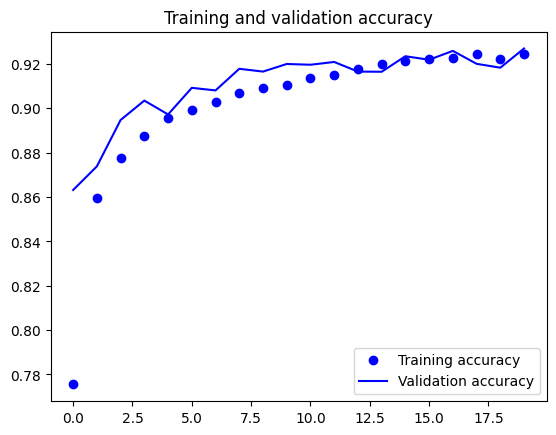

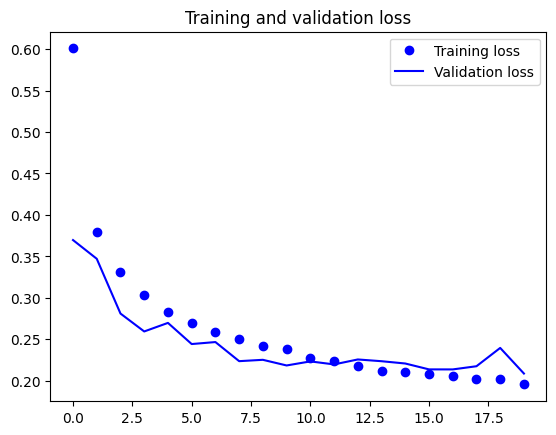

In [51]:
#Graph the accuracy and the loss
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
print(fashion_train.history.keys())

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_auc_1'])


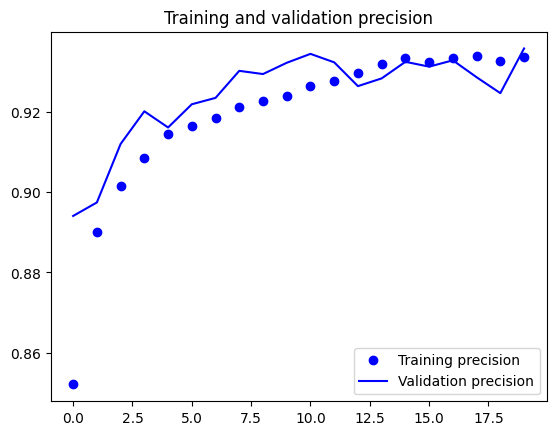

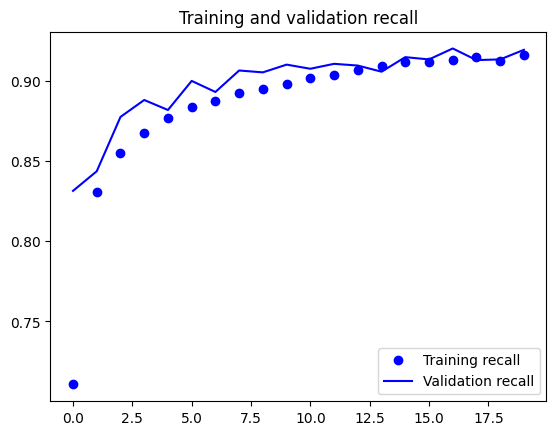

In [54]:
#Graph the accuracy and the loss
precision = fashion_train.history['precision_1']
val_precision = fashion_train.history['val_precision_1']
recall = fashion_train.history['recall_1']
val_recall = fashion_train.history['val_recall_1']
epochs = range(len(precision))
plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [55]:
fashion_model.save("fashion_model_dropout.h5py")

INFO:tensorflow:Assets written to: fashion_model_dropout.h5py\assets


INFO:tensorflow:Assets written to: fashion_model_dropout.h5py\assets


In [56]:
#use predict method, make predictions on the test data
#output of predict method is an array of predicted class labels for each image
predicted_classes = fashion_model.predict(test_X)

313/313 [==============================] - 2s 7ms/step


In [57]:
#converts the predicted probabilities into predicted classes
#argmax used to find the index of the max value in each row of the resulting aray
#sets axis=1 to specify the max value should be found along the rows of the array
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [58]:
predicted_classes.shape, test_Y.shape

((10000,), (10000,))

In [59]:
#visualise the correctly predivted labels
#uses np.where finds the indices where predicted classes match the actual test labels
#len function prints the number of correct labels
#uses a for loop to iterate over the 1st 9 correct predictions
correct = np.where(predicted_classes==test_Y)[0]
print ('Found %d correct labels' % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 9171 correct labels


In [60]:
#visualise the incorrectly predicted labels
#uses same processes however when classes is not equal to test data
incorrect = np.where(predicted_classes!=test_Y)[0]
print ('Found %d incorrect labels' % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

Found 829 incorrect labels


Create a Classification Report

In [61]:
#creates list of classes and then prints out a table of the metrics
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))
#looking at the table can see class 1 and 6 are underperforminh across the board

              precision    recall  f1-score   support

     Class 0       0.79      0.90      0.84      1000
     Class 1       1.00      0.98      0.99      1000
     Class 2       0.85      0.89      0.87      1000
     Class 3       0.94      0.91      0.92      1000
     Class 4       0.90      0.82      0.86      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.79      0.76      0.77      1000
     Class 7       0.96      0.98      0.97      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Build a Confusion Matrix

In [72]:
y_probs = fashion_model.predict(test_X)
#convert into integers
y_preds = np.argmax(y_probs, axis=1) #convert probablities to class labels

313/313 [==============================] - 2s 8ms/step


In [78]:
from matplotlib import colormaps

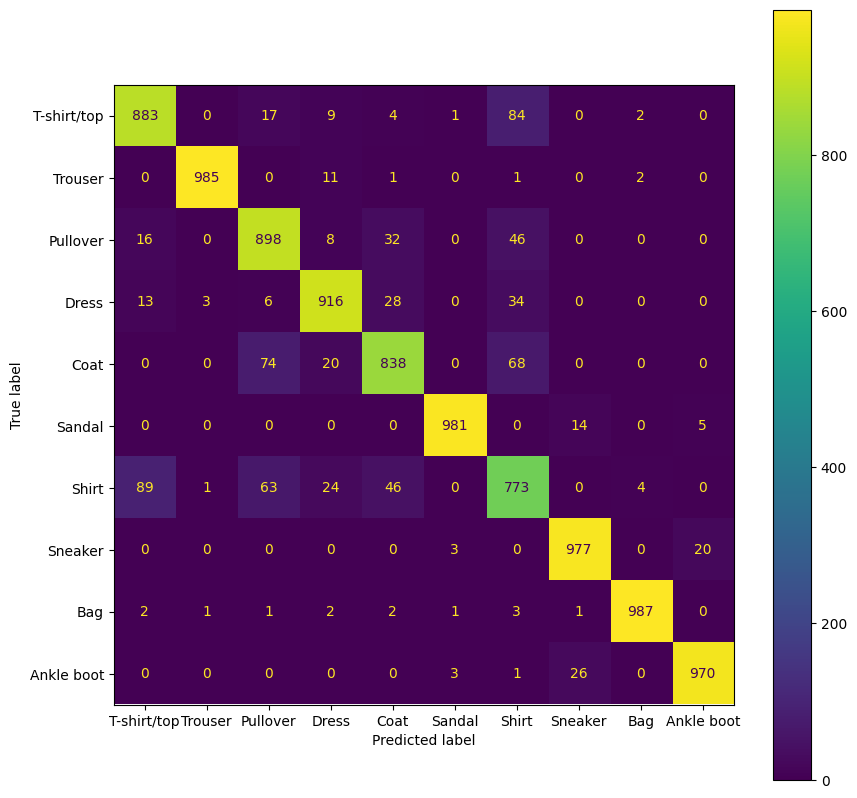

In [80]:
label_name = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
#cm=confusion_matrix(test_Y, y_preds)
cm = confusion_matrix(np.argmax(test_Y_one_hot, axis=1), y_preds)
#plot the matrix
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);
plt.show()

ROC Curve

In [92]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_Y_one_hot[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

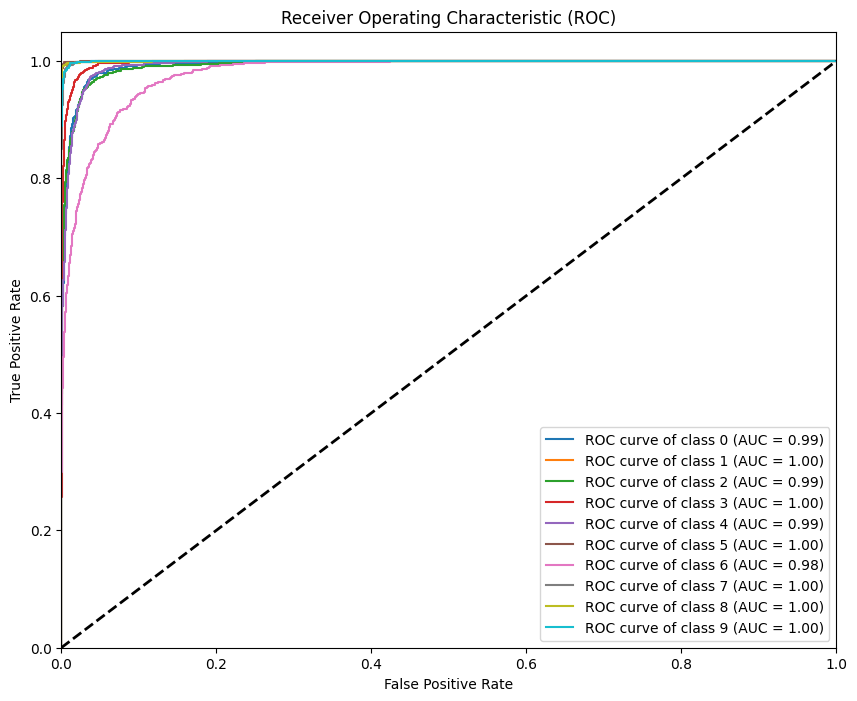

In [91]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Plot Loss Function vs Weights and Bias

In [93]:
#define the loss function
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [94]:
#generate data for w and b
num_points = 50
w_vals = np.linspace(-2, 2, num_points)
b_vals = np.linspace(-2, 2, num_points)
W, B = np.meshgrid(w_vals, b_vals)

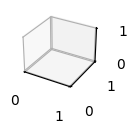

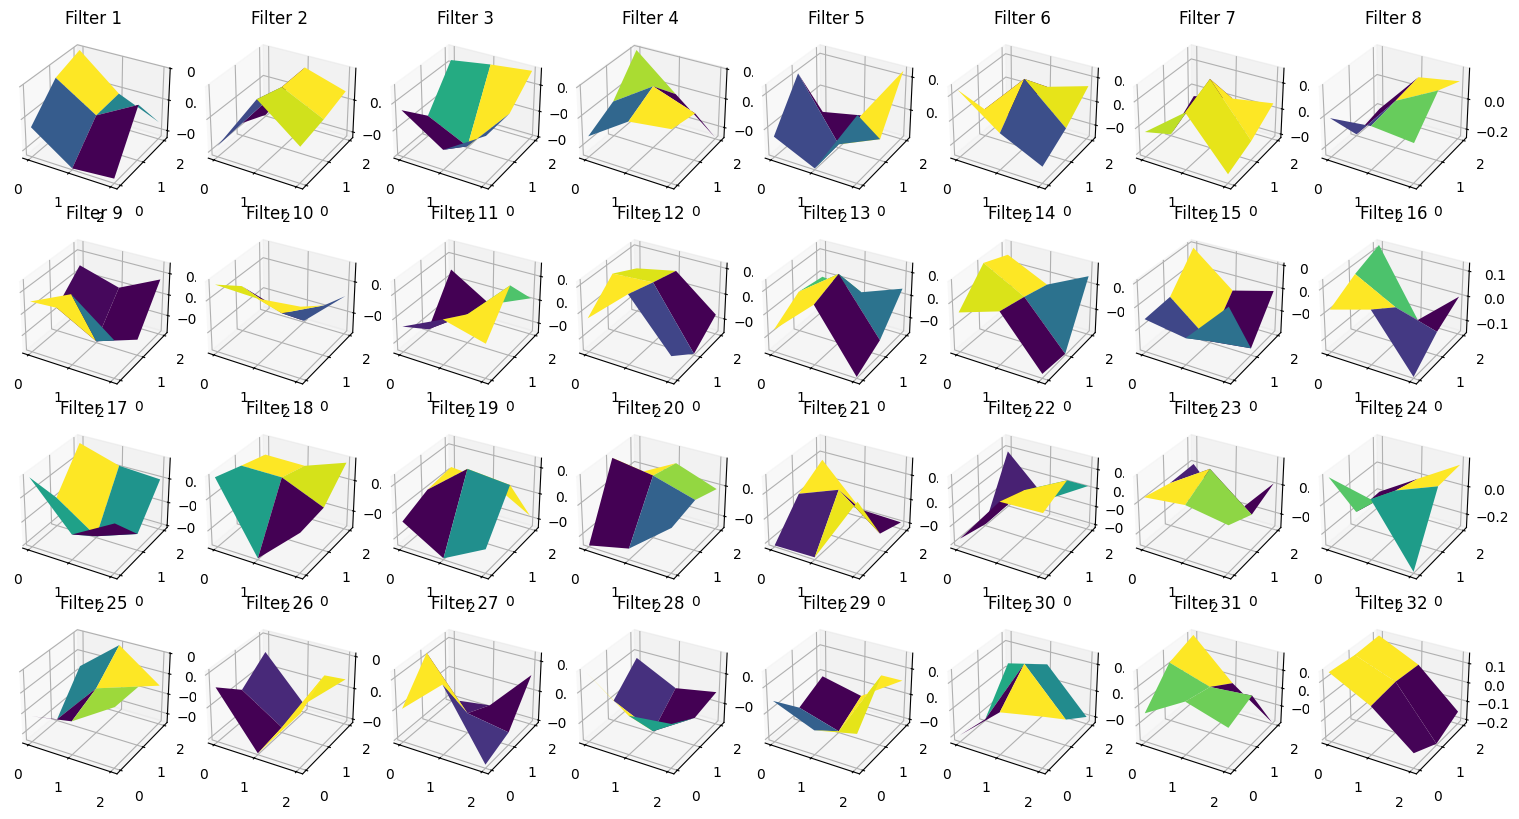

In [97]:
from mpl_toolkits.mplot3d import Axes3D

# Access the filters from the first convolutional layer
filters, biases = fashion_model.layers[0].get_weights()

fig = plt.figure(figsize=(15, 8))
for i in range(filters.shape[3]):  # Iterate over each filter
    ax = fig.add_subplot(4, 8, i + 1, projection='3d')
    
    # Create a meshgrid for X and Y dimensions
    x = np.arange(filters.shape[0])
    y = np.arange(filters.shape[1])
    X, Y = np.meshgrid(x, y)
    
    # Z dimension (weights of the filter)
    Z = filters[:, :, 0, i]  # Assuming single channel (depth 0) and grayscale
    
    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_title('Filter {}'.format(i + 1))

plt.tight_layout()
plt.show()

In [95]:
#calc the loss values for w and b
loss_values = np.zeros_like(W)
for i in range(num_points):
    for j in range(num_points):
        # Example: use your model to predict and calculate loss
        y_pred = W[i, j] * X + B[i, j]  # Replace with your model prediction
        loss_values[i, j] = mean_squared_error(Y, y_pred)  # Replace with your loss function

NameError: name 'X' is not defined

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D surface
surf = ax.plot_surface(W, B, loss_values, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add color bar which maps values to colors

# Customize labels and title
ax.set_xlabel('Weight (w)')
ax.set_ylabel('Bias (b)')
ax.set_zlabel('Loss')
ax.set_title('3D Loss Function Visualization')

plt.show()